# Customer Segmentation using RFM Analysis

## Overview
This project applies **RFM (Recency, Frequency, Monetary) analysis** to segment customers based on purchasing behavior using real-world online retail data. The analysis was implemented end-to-end with a focus on practical business interpretation.

The goal of this analysis is to:
- Identify high-value and at-risk customers
- Enable data-driven marketing strategies
- Compare rule-based segmentation with machine learning approaches

The analysis combines **statistical methods, business logic, and clustering techniques** to produce interpretable and actionable insights, with an emphasis on decisions that can be directly used in marketing strategy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

print("Setup complete")


Setup complete


In [4]:
df = pd.read_excel("../data/Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df = df.dropna(subset=['CustomerID'])


## Data Preparation

The dataset was cleaned and prepared to ensure reliable customer-level analysis:

- Removed transactions with missing `CustomerID`
- Excluded cancelled invoices to retain only completed purchases
- Ensured date fields were handled in datetime format
- Created `TotalPrice` as Quantity × UnitPrice

Only valid customer transactions were retained to compute accurate RFM metrics.

In [7]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]


In [8]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [9]:
df[['InvoiceNo', 'CustomerID', 'Quantity', 'UnitPrice', 'TotalPrice']].head()


,InvoiceNo,CustomerID,Quantity,UnitPrice,TotalPrice
0,536365,17850.0,6,2.55,15.30
1,536365,17850.0,6,3.39,20.34
2,536365,17850.0,8,2.75,22.00
3,536365,17850.0,6,3.39,20.34
4,536365,17850.0,6,3.39,20.34


In [10]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
snapshot_date


Timestamp('2011-12-10 12:50:00')

## RFM Feature Engineering

Each customer was represented using three behavioral dimensions derived from transaction history:

- **Recency**: Number of days since the customer’s most recent purchase
- **Frequency**: Total number of completed transactions
- **Monetary**: Aggregate spending across all purchases

These features provide a compact and interpretable summary of customer engagement and value.

In [ ]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


In [12]:
rfm.describe()


,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,92.518322,4.271952,2053.793018
std,100.009747,7.705493,8988.248381
min,1.000000,1.000000,0.000000
25%,18.000000,1.000000,307.245000
50%,51.000000,2.000000,674.450000
75%,142.000000,5.000000,1661.640000
max,374.000000,210.000000,280206.020000


## RFM Scoring

Quartile-based scoring (1–4) was applied independently to each RFM dimension:

- Higher scores correspond to more desirable customer behavior
- Quartiles reduce sensitivity to extreme outliers
- Scores remain interpretable and comparable across customers

The final **RFM score** is formed by concatenating the individual R, F, and M scores.

In [13]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])

rfm['F_score'] = pd.qcut(
    rfm['Frequency'].rank(method='first'),
    4,
    labels=[1, 2, 3, 4]
)

rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

rfm[['Recency', 'Frequency', 'Monetary', 'R_score', 'F_score', 'M_score']].head()


,Recency,Frequency,Monetary,R_score,F_score,M_score
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,4
12347.0,2,7,4310.00,4,4,4
12348.0,75,4,1797.24,2,3,4
12349.0,19,1,1757.55,3,1,4
12350.0,310,1,334.40,1,1,2


In [14]:
rfm['RFM_Score'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)

rfm[['Recency', 'Frequency', 'Monetary', 'RFM_Score']].head()


,Recency,Frequency,Monetary,RFM_Score
CustomerID,,,,
12346.0,326,1,77183.60,114
12347.0,2,7,4310.00,444
12348.0,75,4,1797.24,234
12349.0,19,1,1757.55,314
12350.0,310,1,334.40,112


In [15]:
def rfm_segment(row):
    if row['RFM_Score'] >= '444':
        return 'Champions'
    elif row['R_score'] == 4 and row['F_score'] >= 3:
        return 'Loyal Customers'
    elif row['R_score'] >= 3 and row['F_score'] <= 2:
        return 'Potential Loyalists'
    elif row['R_score'] <= 2 and row['F_score'] >= 3:
        return 'At Risk'
    else:
        return 'Hibernating'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)
rfm[['Recency', 'Frequency', 'Monetary', 'RFM_Score', 'Segment']].head()


,Recency,Frequency,Monetary,RFM_Score,Segment
CustomerID,,,,,
12346.0,326,1,77183.60,114,Hibernating
12347.0,2,7,4310.00,444,Champions
12348.0,75,4,1797.24,234,At Risk
12349.0,19,1,1757.55,314,Potential Loyalists
12350.0,310,1,334.40,112,Hibernating


## Customer Segmentation

Customers were assigned to business-relevant segments using rule-based RFM logic:

- **Champions**: High recency, frequency, and monetary value
- **Loyal Customers**: Frequent and recent buyers
- **Potential Loyalists**: Recent but less frequent buyers
- **At Risk**: Previously valuable customers showing declining engagement
- **Hibernating**: Low engagement across all RFM dimensions

This rule-based approach prioritizes interpretability and practical business usability.

In [16]:
rfm['Segment'].value_counts()


Segment
Hibernating            2136
Potential Loyalists     666
At Risk                 646
Champions               489
Loyal Customers         402
Name: count, dtype: int64

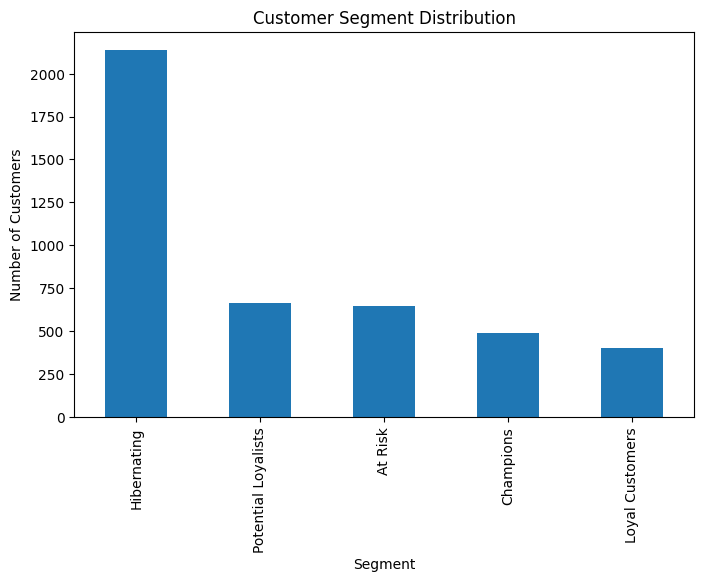

In [17]:
import matplotlib.pyplot as plt

rfm['Segment'].value_counts().plot(
    kind='bar',
    figsize=(8,5),
    title='Customer Segment Distribution'
)
plt.ylabel('Number of Customers')
plt.show()


## Segment Distribution Analysis

Most customers fall into lower-engagement segments such as **Hibernating**, while a relatively small group contributes a disproportionately large share of total revenue.

This distribution highlights two key business priorities:
- Retaining high-value customers who drive the majority of revenue
- Strategically reactivating dormant customers where cost-effective

In [18]:
rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().sort_values('Monetary', ascending=False)


,Recency,Frequency,Monetary
Segment,,,
Champions,7.439673,15.539877,9063.926585
At Risk,119.198142,4.173375,1611.350915
Loyal Customers,8.912935,4.293532,1291.788184
Hibernating,140.640449,2.598783,1131.537005
Potential Loyalists,25.234234,1.447447,753.683514


In [20]:
rfm['R_score'] = rfm['R_score'].astype(int)
rfm['F_score'] = rfm['F_score'].astype(int)
rfm['M_score'] = rfm['M_score'].astype(int)


In [21]:
rfm_scores = rfm.groupby('Segment')[['R_score', 'F_score', 'M_score']].mean()
rfm_scores


,R_score,F_score,M_score
Segment,,,
At Risk,1.719814,3.270898,2.907121
Champions,4.000000,4.000000,4.000000
Hibernating,1.873127,2.051030,2.171816
Loyal Customers,4.000000,3.296020,2.875622
Potential Loyalists,3.352853,1.609610,1.828829


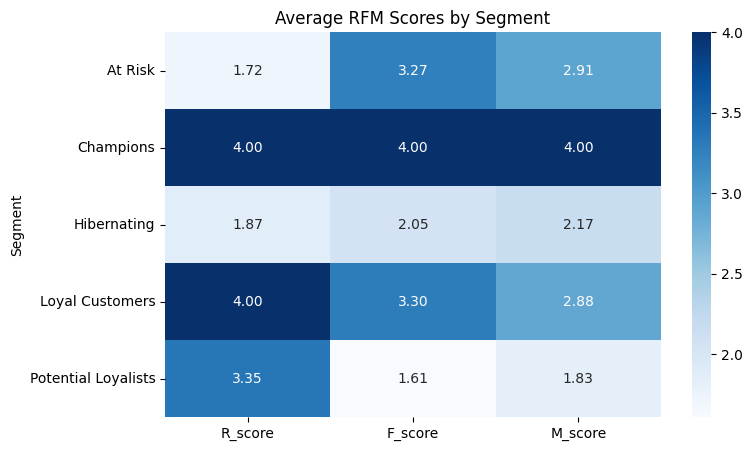

In [22]:
plt.figure(figsize=(8,5))
sns.heatmap(rfm_scores, annot=True, cmap='Blues', fmt=".2f")
plt.title("Average RFM Scores by Segment")
plt.show()


In [23]:
rfm['Weighted_RFM'] = (
    0.4 * rfm['R_score'] +
    0.3 * rfm['F_score'] +
    0.3 * rfm['M_score']
)


In [24]:
segment_revenue = (
    rfm.merge(df[['CustomerID', 'TotalPrice']], on='CustomerID')
       .groupby('Segment')['TotalPrice']
       .sum()
       .sort_values(ascending=False)
)
segment_revenue


Segment
Champions              4432260.100
Hibernating            2416963.043
At Risk                1040932.691
Loyal Customers         519298.850
Potential Loyalists     501953.220
Name: TotalPrice, dtype: float64

<Axes: title={'center': 'Revenue Contribution by Segment'}, xlabel='Segment'>

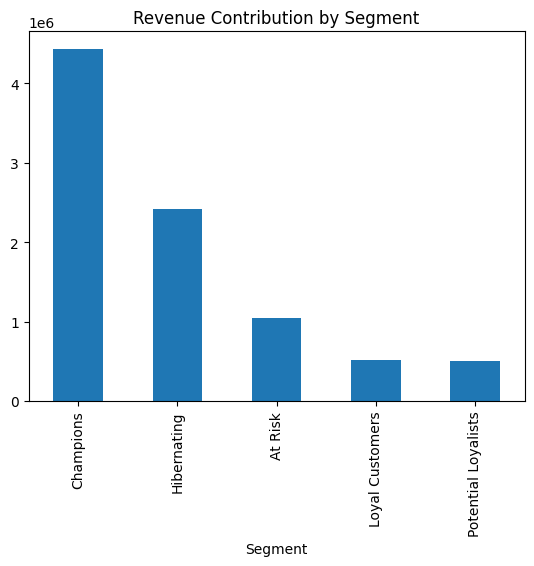

In [25]:
segment_revenue.plot(kind='bar', title='Revenue Contribution by Segment')


## Clustering-Based Segmentation (Extension)

To complement the rule-based RFM segmentation, **KMeans clustering** was applied to standardized RFM features.

This unsupervised approach helps evaluate whether naturally emerging customer groups align with business-defined RFM segments.


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = rfm[['Recency', 'Frequency', 'Monetary']]
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)


In [27]:
rfm['Decay_Monetary'] = rfm['Monetary'] / rfm['Recency']


In [28]:
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()


,Recency,Frequency,Monetary
Cluster,,,
0,28.763975,4.605978,1745.543145
1,284.563994,1.357243,501.728820
2,13.521739,35.391304,22165.731196
3,129.826863,2.089192,765.903957
4,6.714286,65.571429,184143.690000


In [29]:
rfm['Cluster'].value_counts()


Cluster
0    2576
3     953
1     711
2      92
4       7
Name: count, dtype: int64

In [30]:
pd.crosstab(rfm['Segment'], rfm['Cluster'])


Cluster,0,1,2,3,4
Segment,,,,,
At Risk,257,68,1,320,0
Champions,400,0,84,0,5
Hibernating,852,643,7,633,1
Loyal Customers,402,0,0,0,0
Potential Loyalists,665,0,0,0,1


In [31]:
rfm['Decay_Monetary'] = rfm['Monetary'] / rfm['Recency']


In [32]:
rfm['Decay_Monetary'] = rfm['Monetary'] / (rfm['Recency'] + 1)


In [33]:
rfm.groupby('Segment')['Decay_Monetary'].mean().sort_values(ascending=False)


Segment
Champions              2235.612743
Loyal Customers         198.838673
Potential Loyalists     161.265946
Hibernating              29.061831
At Risk                  17.806756
Name: Decay_Monetary, dtype: float64

In [34]:
rfm['Weighted_RFM'] = (
    0.4 * rfm['R_score'] +
    0.3 * rfm['F_score'] +
    0.3 * rfm['M_score']
)


In [35]:
rfm.groupby('Segment')['Weighted_RFM'].mean().sort_values(ascending=False)


Segment
Champions              4.000000
Loyal Customers        3.451493
At Risk                2.541331
Potential Loyalists    2.372673
Hibernating            2.016105
Name: Weighted_RFM, dtype: float64

In [36]:
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)
segment_revenue


Segment
Champions              4432260.100
Hibernating            2416963.043
At Risk                1040932.691
Loyal Customers         519298.850
Potential Loyalists     501953.220
Name: Monetary, dtype: float64

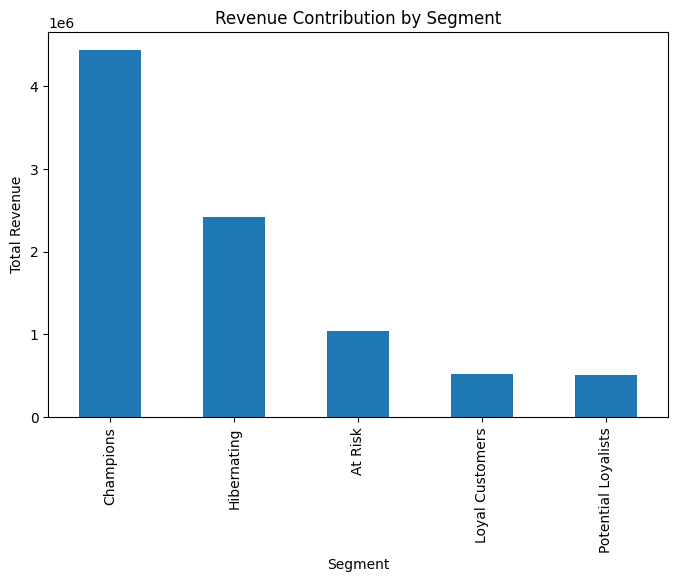

In [37]:
segment_revenue.plot(kind='bar', figsize=(8,5), title='Revenue Contribution by Segment')
plt.ylabel('Total Revenue')
plt.show()


In [38]:
cust_revenue = rfm['Monetary'].sort_values(ascending=False)
cum_rev = cust_revenue.cumsum() / cust_revenue.sum()

cum_rev.head(10)


CustomerID
14646.0    0.031444
18102.0    0.060581
17450.0    0.082413
16446.0    0.101318
14911.0    0.117457
12415.0    0.131475
14156.0    0.144647
17511.0    0.154865
16029.0    0.163958
12346.0    0.172619
Name: Monetary, dtype: float64

In [39]:
(cum_rev <= 0.8).mean()


np.float64(0.26088960589997695)

In [40]:
segment_actions = {
    'Champions': 'Reward loyalty, exclusive offers',
    'Loyal Customers': 'Upsell & cross-sell',
    'Potential Loyalists': 'Targeted promotions',
    'At Risk': 'Win-back campaigns',
    'Hibernating': 'Reactivation or cost control'
}


In [42]:
(cum_rev <= 0.8).mean()


np.float64(0.26088960589997695)

## Revenue Concentration Analysis

Approximately **26% of customers account for 80% of total revenue**, indicating a strong Pareto effect in customer value distribution.

This suggests that:
- Targeted marketing is likely to deliver higher ROI than broad campaigns
- Retaining high-value customers is critical to long-term business sustainability

In [43]:
rfm['Action'] = rfm['Segment'].map(segment_actions)
rfm[['Recency', 'Frequency', 'Monetary', 'Segment', 'Action']].head()


,Recency,Frequency,Monetary,Segment,Action
CustomerID,,,,,
12346.0,326,1,77183.60,Hibernating,Reactivation or cost control
12347.0,2,7,4310.00,Champions,"Reward loyalty, exclusive offers"
12348.0,75,4,1797.24,At Risk,Win-back campaigns
12349.0,19,1,1757.55,Potential Loyalists,Targeted promotions
12350.0,310,1,334.40,Hibernating,Reactivation or cost control


In [44]:
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)
segment_revenue


Segment
Champions              4432260.100
Hibernating            2416963.043
At Risk                1040932.691
Loyal Customers         519298.850
Potential Loyalists     501953.220
Name: Monetary, dtype: float64

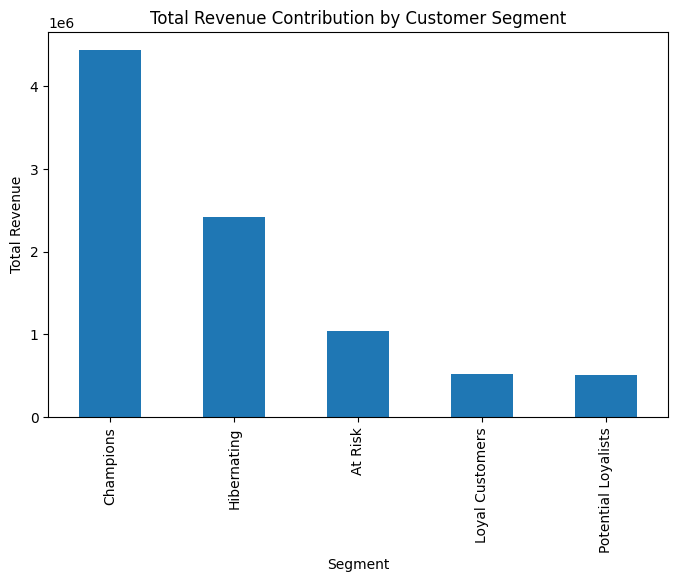

In [45]:
segment_revenue.plot(
    kind='bar',
    figsize=(8,5),
    title='Total Revenue Contribution by Customer Segment'
)
plt.ylabel('Total Revenue')
plt.show()


## RFM vs Clustering Comparison

The clustering results broadly align with RFM-based segments, validating the rule-based approach.

RFM segmentation remains preferable due to:
- Greater interpretability
- Easier deployment in business settings
- Clear mapping to marketing actions


In [46]:
pd.crosstab(rfm['Segment'], rfm['Cluster'])


Cluster,0,1,2,3,4
Segment,,,,,
At Risk,257,68,1,320,0
Champions,400,0,84,0,5
Hibernating,852,643,7,633,1
Loyal Customers,402,0,0,0,0
Potential Loyalists,665,0,0,0,1


In [47]:
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()


,Recency,Frequency,Monetary
Cluster,,,
0,28.763975,4.605978,1745.543145
1,284.563994,1.357243,501.728820
2,13.521739,35.391304,22165.731196
3,129.826863,2.089192,765.903957
4,6.714286,65.571429,184143.690000


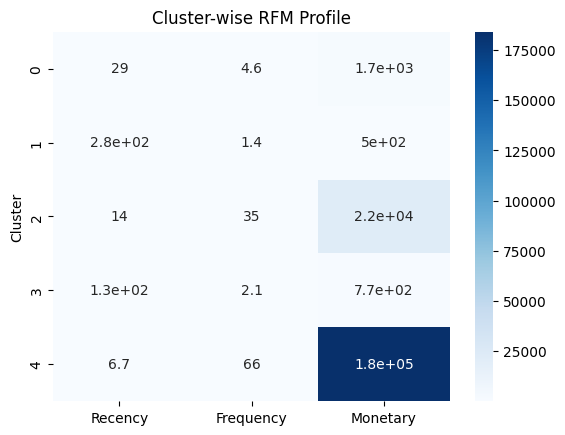

In [48]:
sns.heatmap(
    rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean(),
    annot=True,
    cmap='Blues'
)
plt.title('Cluster-wise RFM Profile')
plt.show()


In [49]:
rfm.to_csv('rfm_customer_segmentation_final.csv')


## Methodology
RFM segmentation was chosen for its interpretability and robustness.
Quartile-based scoring avoids sensitivity to outliers and supports consistent customer comparison.

## Limitations
- Assumes equal importance of R, F, and M
- Ignores seasonality
- Does not explicitly model time decay

## Future Work
- Weighted RFM optimization
- Time-decayed RFM
- Survival analysis for churn prediction
- Predictive CLV modeling

*This framework can be extended into a production-ready customer analytics pipeline.*
